# Почему Логистическая регрессия - линейная модель. Переход к нелинейности.

In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

from common import *

import os 

exec_str = os.getcwd()[:os.getcwd().find('prog/')+len('prog/')]
from sys import path

if not exec_str in path:
    path.append(exec_str)
    print('exec added to path')

from DS_common import visualisations
from data_loader import load_data

import funs_params as fp

exec added to path


# Подготовительный этап

## Сренерируем входной набор данных


In [2]:
# объем генерируемого набора данных
n = 600
# функция указывает линейное правило дикриминации
lin_discr_fun = lambda x1, x2: x1 - x2 > 0.4
# указывает кусочно - линейно правило дикриминации
pl_discr_fun = lambda x: fp.a1*x[0] + fp.a2*x[1] + fp.a > 0 \
    if (x[0] < fp.col_point[0]) \
    else fp.b1*x[0] + fp.b2*x[1] + fp.b > 0


Массив дву-размерных точек, разделенный на две группы по некоторому линейному правилу

X1 = np.random.rand(n).reshape(n,1)
X2 = np.random.rand(n).reshape(n,1)
Y = lin_discr_fun(X1, X2).reshape(n,1)

В целом полученный массив меня устравивает, потому отложу его в файл

np.savetxt('2dim_data_for_logit.csv', np.concatenate([X1,X2,Y], axis = 1), delimiter=',')

Загрузим полученный файл

In [3]:
X, Y = load_data("2dim_data_for_logit.csv")

## Нужна сигмоид функция

In [4]:
sim_fun = lambda x: 1/(1+np.exp(-x))

# Диaграмма рассеяния с цветом распределяющим по классам

## Отрисовка

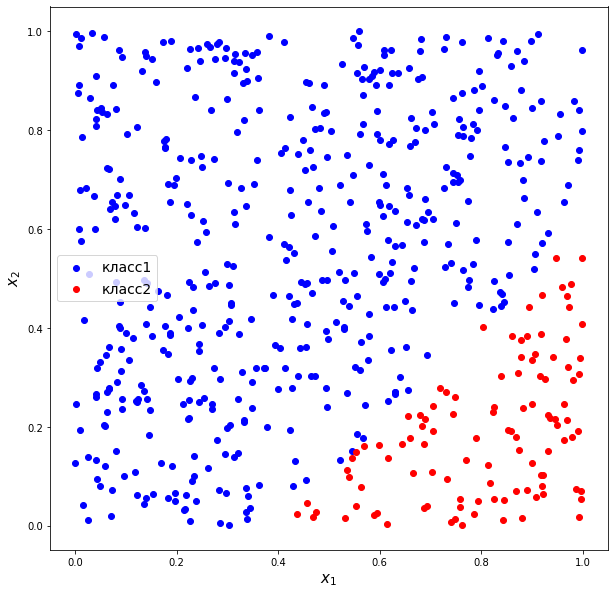

In [5]:
plt.figure(figsize = [10,10])
draw_my_scatter(X[:,0],X[:,1],Y)
plt.savefig('pictures/scatter2d_classes_linear.png')

# Покажем как работает Logit для данного случая

## Строим модель на данных

In [6]:
model = LogisticRegression().fit(X, Y)

## Нанесем двумерную сигмоиду

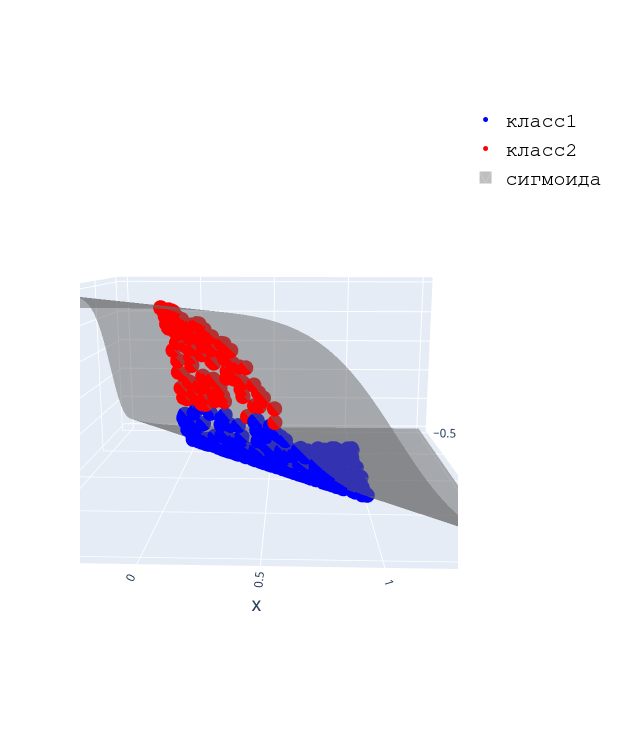

In [8]:
from plotly.subplots import make_subplots

x1 = np.linspace(-0.5, 1.5, 50)
x2 = np.linspace(-0.5, 1.5, 50)

x1, x2 = np.meshgrid(x1,x2)
pp = sim_fun(
    x1*model.coef_[0,0] + x2*model.coef_[0,1] + model.intercept_[0]
)

i_ind, j_ind, k_ind = visualisations.get_meshtraces(x1)

fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"type": "mesh3d"}]]
)

fig.append_trace(
    go.Scatter3d(
        x = X[np.invert(Y), 0].flatten(),
        y = X[np.invert(Y), 1].flatten(),
        z = model.predict_proba(X[np.invert(Y), :])[:,1].flatten(),
        marker = {'size':5, 'color':'#0000ff'},
        name = 'класс1',
        mode = 'markers',
    ),
    row = 1,col = 1
)


fig.append_trace(
    go.Scatter3d(
        x = X[Y, 0].flatten(),
        y = X[Y, 1].flatten(),
        z = model.predict_proba(X[Y, :])[:,1].flatten(),
        marker = {'size':5, 'color':'red'},
        name = 'класс2',
        mode = 'markers'
    ),
    row = 1,col = 1
)

fig.append_trace(
    go.Mesh3d(    
        x=x1.ravel(),
        y=x2.ravel(),
        z=pp.ravel(),
        opacity=0.5, color='gray',
        colorbar_thickness=25, 
        flatshading=True,
        showlegend = True,
        name = 'сигмоида',
        i = i_ind, j = j_ind, k = k_ind
    ),
    row = 1,col = 1
)


fig.update_layout(
    height=750, width=1500
)

fig.layout.scene1.camera.eye=dict(x=-1.4, y=-1.4, z=0.5) 

fig.layout.scene1.xaxis=dict(title_text = "x", titlefont = {'size':20}) 
fig.layout.scene1.yaxis=dict(title_text = "x", titlefont = {'size':20}) 
fig.layout.scene1.zaxis=dict(title_text = "p", titlefont = {'size':20}) 
fig.update_layout(    
    legend=dict(
        font=dict(
            family="Courier",
            size=20,
            color="black",
        )
    )
)

fig.show()
fig.write_image('pictures/scatter3d_with_sigmoid.png')
fig.write_html("pictures/scatter3d_with_sigmoid.html")

# Усложняем задачу -- теперь предполагается кусочно-линейная дискриминирующая функция

## Набор данных с новой функцией

Y = np.fromiter((map(pl_discr_fun, X)), dtype = 'bool').reshape(n,1)

Закинем данные с новой функцтей для загрузки к нейронной сети

np.savetxt('2dim_data_for_nn.csv', np.concatenate([X[:, [0]],X[:, [1]],Y], axis = 1), delimiter=',')

## Подгрузим предсозданные данные

In [8]:
X, Y = load_data("2dim_data_for_nn.csv")

## Модель на новом наборе данных

In [9]:
model = LogisticRegression().fit(X,Y.ravel())

## Данные для отрисовки

### Выберем точку отсечения $p'$ минимизирующую ошибку 

In [10]:
probs_hat = model.predict_proba(X)[:,1].reshape(n,1)
p_bar = get_p_bar(Y, probs_hat)

### Дискриминирующая линия

In [11]:
#x1 = (-np.log((1 - p_bar)/p_bar)-model.intercept_[0])/model.coef_[0,0]
x2_1 = (-np.log((1 - p_bar)/p_bar)-model.intercept_[0])/model.coef_[0,1]
x2_2 = (-np.log((1 - p_bar)/p_bar)-model.intercept_[0]-model.coef_[0,0])/model.coef_[0,1]

### Узнаем какие предсказания были правильными а какие фальшивыми

In [12]:
is_correct_pred = ((probs_hat > p_bar).ravel() == Y)

## Нанесем соответсвующую диаграмму рассеяния

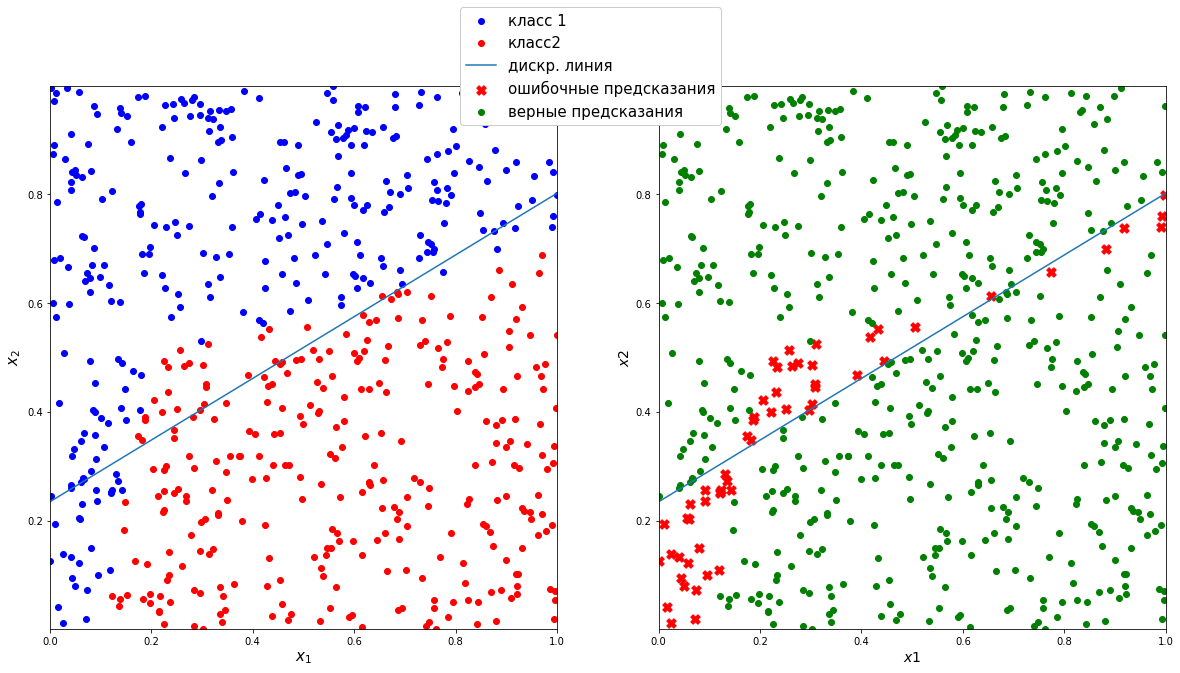

In [13]:
z=pp.ravel(),fig = plt.figure(figsize = [20,10])

plt.subplot(121)
draw_my_scatter(X[:,[0]],X[:,[1]],Y)
plt.plot([0,1], [x2_1, x2_2])
plt.margins(x = 0, y = 0)

plt.subplot(122)
def groups_plot(condition, **kawargs):
    plt.scatter(X[:,0][condition], X[:,1][condition], **kawargs)


# ошибки
groups_plot(
    np.invert(is_correct_pred), 
    marker = 'X', color = 'red', s = 90
)
# правильные
groups_plot(
    is_correct_pred, 
    marker = 'o', color = 'green'
)
plt.plot([0,1], [x2_1, x2_2])
plt.margins(x = 0, y = 0)
plt.xlabel('$x1$', fontsize = 14)
plt.ylabel('$x2$', fontsize = 14)


fig.axes[0].get_legend().remove()
fig.legend(
    ['класс 1', 'класс2', 'дискр. линия', 
    'ошибочные предсказания', 'верные предсказания'],
    fontsize = 15, loc = 9, framealpha = 1
)

plt.savefig('pictures/nonlinear_for_logit.png')